# Factorized parameter estimation

This tutorial shows how to run [factorized parameter estimation](https://arxiv.org/abs/2210.16278) (i.e., sampling over intrinsic parameters while marginalizing over extrinsic parameters, then reconstructing the full posterior in postprocessing). In this notebook, we'll use it in a form that is restricted to quadrupolar, aligned-spin waveforms.

In [1]:
# Ensure only one core is used
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

import sys
path_to_cogwheel = '..'
sys.path.append(path_to_cogwheel)

import requests
import numpy as np
import pandas as pd
import h5py
import glob

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
lal.swig_redirect_standard_output_error(False);  # Otherwise LAL may run slow on notebooks

from cogwheel import posterior, data, sampling, gw_plotting, gw_utils

%matplotlib widget

/Users/tejaswi/miniconda3/envs/cogwheel_newlal/lib/python3.10/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.10 is maybe too old for this OS.
  warnings.warn(


In [2]:
import gwosc

## Directory setup
Edit these as desired:

In [3]:
parentdir = 'xgmdc-runs'  # Directory that will contain parameter estimation runs
dataroot = 'xgmdc-data'   # Directory that contains the subdirectories with frame files

## Try GW150914

In [3]:
# We already have the data for this event along with the repository
eventname = 'GW150914'
mchirp_guess = data.EVENTS_METADATA['mchirp'][eventname]  # or whatever you like...
approximant = 'IMRPhenomXAS'
prior_name = 'AlignedSpinLVCPriorComovingVT'

post = posterior.Posterior.from_event(eventname, 
                                      mchirp_guess, 
                                      approximant, 
                                      prior_class='IntrinsicAlignedSpinLVCPrior',
                                      prior_kwargs={'symmetrize_lnq': True})

Searching incoherent solution for GW150914
Set intrinsic parameters, lnL = 295.07439318124466
Set time, lnL(H) = 203.9986853358002
Set sky location, lnL = 295.0649631087958
Set phase and distance, lnL = 295.0649631087958
Set mchirp_range = (19.58050541526217, 113.27228833032449)


In [4]:
%%time

# Run the sampler
pym = sampling.PyMultiNest(post)
pym.run_kwargs['n_live_points'] = 128

rundir = pym.get_rundir(parentdir)
pym.run(rundir)

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  128
 dimensionality =    4
 *****************************************************
 ln(ev)=   267.70457975494730      +/-  0.23643709123824630     
 Total Likelihood Evaluations:         2865
 Sampling finished. Exiting MultiNest
CPU times: user 18.6 s, sys: 223 ms, total: 18.8 s
Wall time: 18.9 s


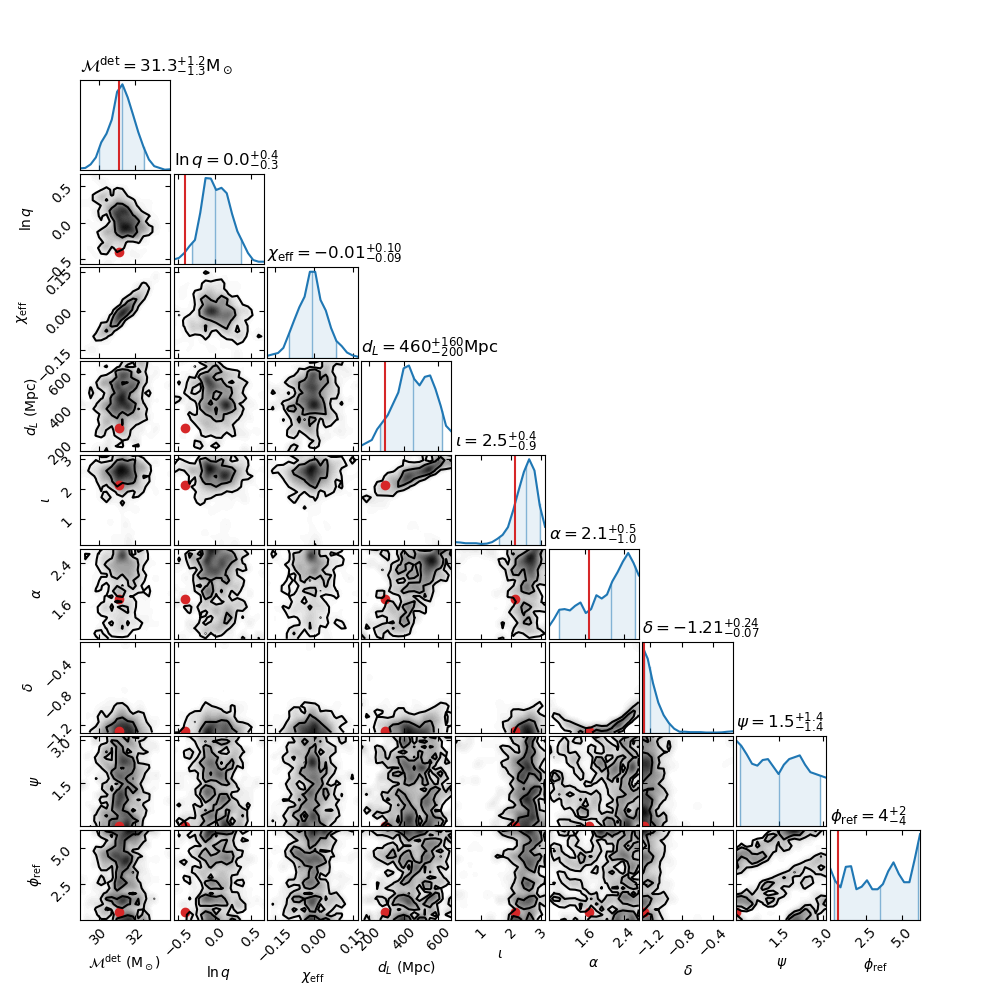

In [5]:
# Plot the posteriors
# Load samples
samples = pd.read_feather(rundir/'samples.feather')

plot_params = ['mchirp', 'lnq', 'chieff', 'd_luminosity', 'iota', 
               'ra', 'dec', 'psi', 'phi_ref']

if 'chieff' not in samples.keys():
    samples['chieff'] = gw_utils.chieff(samples['m1'], samples['m2'], samples['s1z'], samples['s2z'])

cp = gw_plotting.CornerPlot(samples, params=plot_params)
cp.plot(max_n_ticks=3)

# I'm going to mark the relative binning reference 
# waveform as the 'truth' in the plot for the sake of showing something
ref_par_dic = post.likelihood.par_dic_0.copy()
ref_par_dic.update(post.prior.inverse_transform(**ref_par_dic))

cp.scatter_points(ref_par_dic, colors=['C3'])

## Try GW170817

In [7]:
# This event's data isn't there in the repository, so let's download it
eventname = 'GW170817'

outdir = data.GWOSC_FILES_DIR/eventname
# Create the output directory if it doesn't exist
os.makedirs(outdir, exist_ok=True)

urls = gwosc.locate.get_event_urls('GW170817', version=2)  # Cleaned data for GW170817

# Download all the files
for url in urls:
    response = requests.get(url, allow_redirects=True)
    if response.status_code == 200:
        filename = os.path.join(outdir, os.path.basename(url))
        if not os.path.isfile(filename):
            print(f"Downloading {url}")
            with open(filename, 'wb') as f:
                f.write(response.content)
    else:
        print(f"Failed to download {url}, status code {response.status_code}")

filenames = [outdir/url.split('/')[-1] for url in urls]
detector_names = tuple(filename.name[0] for filename in filenames)
tgps = gwosc.datasets.event_gps(eventname)

# We need to create an eventdata first
event_data = data.EventData.from_timeseries(
    filenames, eventname.split('-')[0], detector_names, tgps, t_before=256., fmax=1600.)

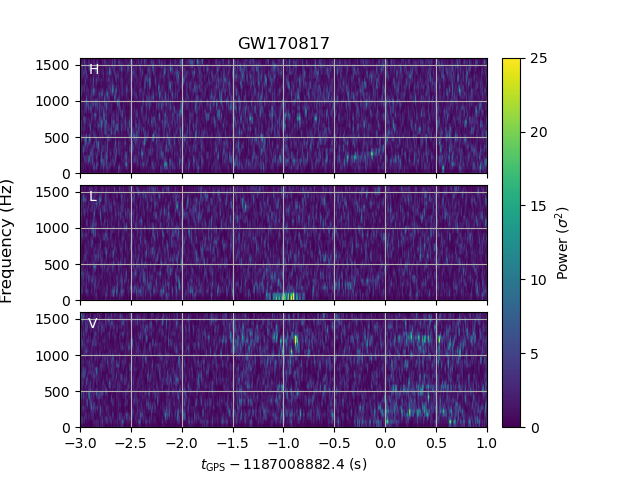

In [10]:
# Let's check if the data contains the event
event_data.specgram((-3, 1))

In [11]:
%%time

# Let's create the posterior object
mchirp_guess = 1.198
post = posterior.Posterior.from_event(event_data, 
                                      mchirp_guess, 
                                      'IMRPhenomXAS', 
                                      prior_class='IntrinsicAlignedSpinLVCPrior',
                                      prior_kwargs={'symmetrize_lnq': True})

Searching incoherent solution for GW170817
Set intrinsic parameters, lnL = 583.7924794248127
Set time, lnL(L) = 379.4526563054465
Set sky location, lnL = 582.5915679771801
Set phase and distance, lnL = 582.5915679771801
Set mchirp_range = (1.1945941010751824, 1.2019337587675765)


In [12]:
%%time

# Run the sampler
pym = sampling.PyMultiNest(post)
pym.run_kwargs['n_live_points'] = 128

rundir = pym.get_rundir(parentdir)
pym.run(rundir)

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  128
 dimensionality =    4
 *****************************************************


 ln(ev)=   509.94759754735651      +/-  0.27645690909647197     
 Total Likelihood Evaluations:         9607
 Sampling finished. Exiting MultiNest
CPU times: user 3min 8s, sys: 1.16 s, total: 3min 9s
Wall time: 3min 10s


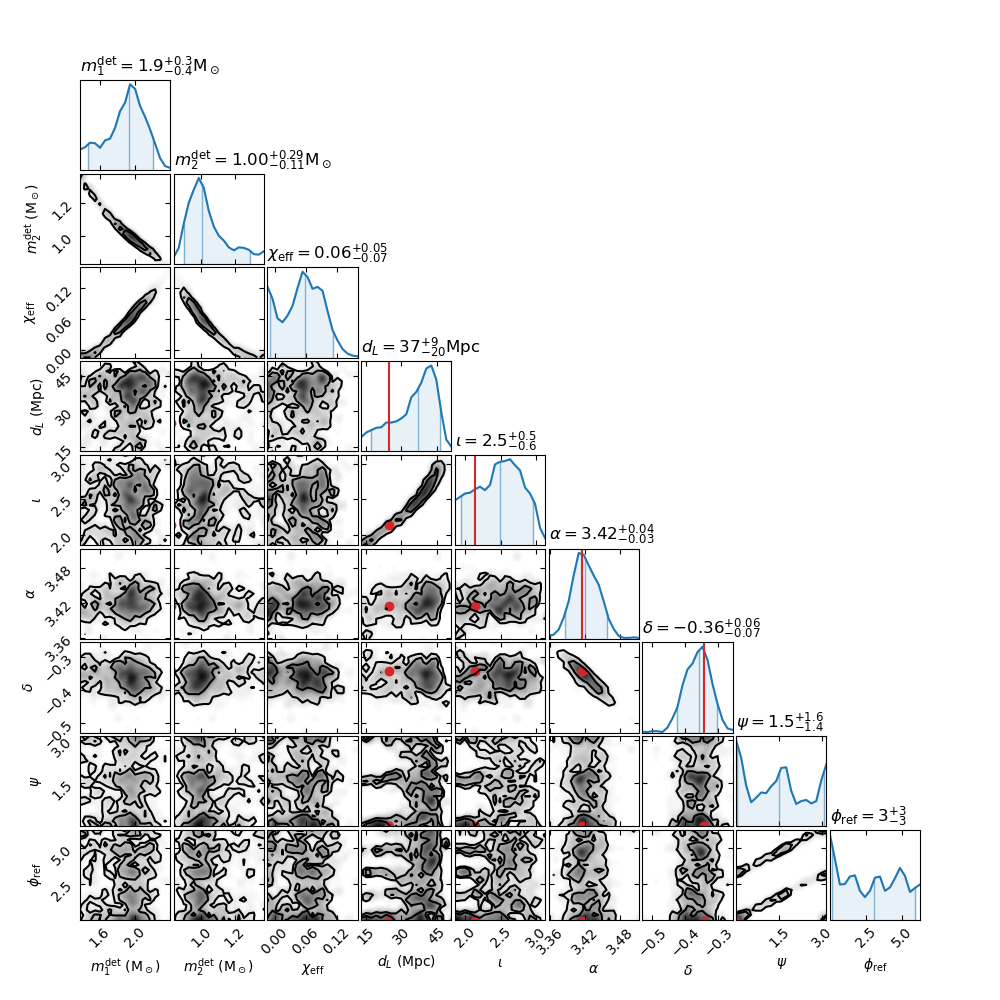

In [14]:
# Plot the posteriors
# Load samples
samples = pd.read_feather(rundir/'samples.feather')

# plot_params = ['mchirp', 'lnq', 'chieff', 'd_luminosity', 'iota', 
#                'ra', 'dec', 'psi', 'phi_ref']
plot_params = ['m1', 'm2', 'chieff', 'd_luminosity', 'iota', 
               'ra', 'dec', 'psi', 'phi_ref']

if 'chieff' not in samples.keys():
    samples['chieff'] = gw_utils.chieff(samples['m1'], samples['m2'], samples['s1z'], samples['s2z'])

cp = gw_plotting.CornerPlot(samples, params=plot_params)
cp.plot(max_n_ticks=3)

# I'm going to mark the relative binning reference 
# waveform as the 'truth' in the plot for the sake of showing something
ref_par_dic = post.likelihood.par_dic_0.copy()
ref_par_dic.update(post.prior.inverse_transform(**ref_par_dic))

cp.scatter_points(ref_par_dic, colors=['C3'])

# MDC tests

## Read the data from the frame files

In [4]:
eventname = 'GW150914-inj'
t0 = 1895652882
fs = 4096

filenames = []
channel_names = []
detector_names = []

# Go through the various detectors and analyze them together
# Start with a single detector
for detector, detector_name in zip(['CE20',], 
                                   ['CEA20',]):
# for detector, detector_name in zip(['CE20', 'CE40', 'ET1', 'ET2', 'ET3'], 
#                                    ['CEA20', 'CEB40', 'ET110', 'ET210', 'ET310']):
    basename = f"{detector}-{t0}-{fs}.gwf"
    filename = os.path.join(dataroot, detector, basename)
    channel_name = f"{detector}:INJ"

    if not os.path.isfile(filename):
        print(f"{filename} not found!")
        continue

    filenames.append(filename)
    channel_names.append(channel_name)
    detector_names.append(detector_name)

detector_names = tuple(detector_names)

In [5]:
# Rough guess for the event's time
tgps = 1895656192.182722

In [6]:
# We haven't implemented antenna patterns that vary within the event's duration, so set fmin to 8 to avoid systematic errors
event_data = data.EventData.from_timeseries(
    filenames, eventname, detector_names, tgps, channel_names, t_before=128., fmax=1600., fmin=8)

/Users/tejaswi/miniconda3/envs/cogwheel_newlal/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/tejaswi/miniconda3/envs/cogwheel_newlal/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/tejaswi/miniconda3/envs/cogwheel_newlal/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


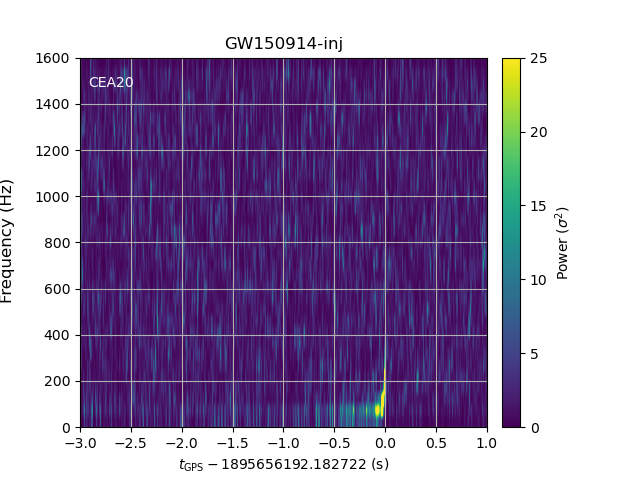

In [7]:
event_data.specgram((-3, 1))

In [8]:
%%time

# Create the posterior object
post = posterior.Posterior.from_event(event=event_data,
                                      mchirp_guess=30,
                                      approximant='IMRPhenomXAS',
                                      prior_class='IntrinsicAlignedSpinLVCPrior',
                                      prior_kwargs={'symmetrize_lnq': True})

Searching incoherent solution for GW150914-inj
Set intrinsic parameters, lnL = 506.0551990399421
Set time, lnL(CEA20) = 506.1044090928641
Set sky location, lnL = 506.1044090928698
Set phase and distance, lnL = 506.1044090928698
Set mchirp_range = (18.851243121063256, 98.07438417909911)
CPU times: user 20.4 s, sys: 4.25 s, total: 24.6 s
Wall time: 24.7 s


In [9]:
%%time

# Run the sampler
pym = sampling.PyMultiNest(post)
pym.run_kwargs['n_live_points'] = 128

rundir = pym.get_rundir(parentdir)
pym.run(rundir)

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  128
 dimensionality =    4
 *****************************************************
 ln(ev)=   504.01421070129049      +/-  0.29642021348387743     
 Total Likelihood Evaluations:         8234
 Sampling finished. Exiting MultiNest
CPU times: user 29.3 s, sys: 268 ms, total: 29.6 s
Wall time: 29.7 s


In [10]:
# Load samples
samples = pd.read_feather(rundir/'samples.feather')

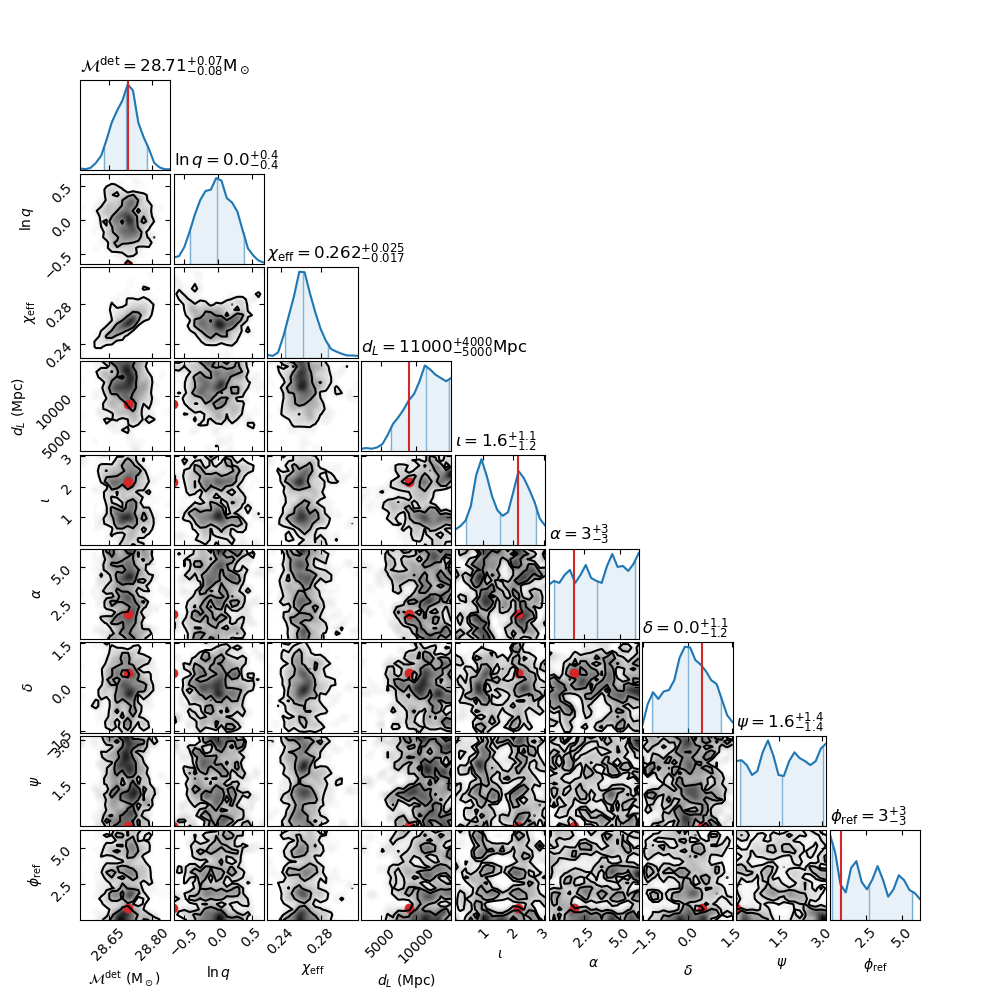

In [11]:
plot_params = ['mchirp', 'lnq', 'chieff', 'd_luminosity', 'iota', 
               'ra', 'dec', 'psi', 'phi_ref']

if 'chieff' not in samples.keys():
    samples['chieff'] = gw_utils.chieff(samples['m1'], samples['m2'], samples['s1z'], samples['s2z'])

cp = gw_plotting.CornerPlot(samples, params=plot_params)
cp.plot(max_n_ticks=3)

# I couldn't figure out the true parameters for the injection from the .h5 
# files as none of the tc seemed to match tgps
# In the absence of that, I'm going to mark the relative binning reference 
# waveform as the 'truth' in the plot for the sake of showing something
ref_par_dic = post.likelihood.par_dic_0.copy()
ref_par_dic.update(post.prior.inverse_transform(**ref_par_dic))

cp.scatter_points(ref_par_dic, colors=['C3'])

## Multiple events

In [12]:
eventname = 'GW150914-inj'
t0 = 1895652882
fs = 4096

filenames = []
channel_names = []
detector_names = []

# Go through the various detectors and analyze them together
# Start with a single detector
for detector, detector_name in zip(['CE20', 'CE40'], 
                                   ['CEA20', 'CEB40']):
# for detector, detector_name in zip(['CE20', 'CE40', 'ET1', 'ET2', 'ET3'], 
#                                    ['CEA20', 'CEB40', 'ET110', 'ET210', 'ET310']):
    basename = f"{detector}-{t0}-{fs}.gwf"
    filename = os.path.join(dataroot, detector, basename)
    channel_name = f"{detector}:INJ"

    if not os.path.isfile(filename):
        print(f"{filename} not found!")
        continue

    filenames.append(filename)
    channel_names.append(channel_name)
    detector_names.append(detector_name)

detector_names = tuple(detector_names)

In [13]:
# We haven't implemented antenna patterns that vary within the event's duration, so set fmin to 8 to avoid systematic errors
event_data = data.EventData.from_timeseries(
    filenames, eventname, detector_names, tgps, channel_names, t_before=128., fmax=1600., fmin=8)

/Users/tejaswi/miniconda3/envs/cogwheel_newlal/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/tejaswi/miniconda3/envs/cogwheel_newlal/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/tejaswi/miniconda3/envs/cogwheel_newlal/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


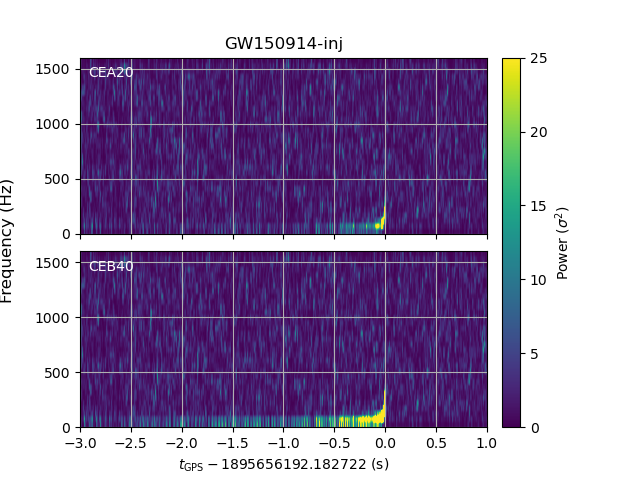

In [14]:
event_data.specgram((-3, 1))

In [18]:
%%time

# Create the posterior object
post = posterior.Posterior.from_event(event=event_data,
                                      mchirp_guess=30,
                                      approximant='IMRPhenomXAS',
                                      prior_class='IntrinsicAlignedSpinLVCPrior',
                                      prior_kwargs={'symmetrize_lnq': True}, 
                                      likelihood_kwargs = {'coherent_score': {'sky_dict_kwargs': {'f_sampling': 2**15}}}
                                     )

Searching incoherent solution for GW150914-inj
Set intrinsic parameters, lnL = 2116.690685712632
Set time, lnL(CEB40) = 1615.2477835580933
Set sky location, lnL = 2118.670919676015
Set phase and distance, lnL = 2118.670919676015
Set mchirp_range = (18.848929225931048, 98.02362978587472)


CPU times: user 33.9 s, sys: 9.72 s, total: 43.6 s
Wall time: 47.3 s


In [19]:
%%time

# Run the sampler
pym = sampling.PyMultiNest(post)
pym.run_kwargs['n_live_points'] = 128

rundir = pym.get_rundir(parentdir)
pym.run(rundir)

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  128
 dimensionality =    4
 *****************************************************


 ln(ev)=   2328.8729374995419      +/-  0.33348247889382943     
 Total Likelihood Evaluations:         7546
 Sampling finished. Exiting MultiNest
CPU times: user 11min 4s, sys: 4.44 s, total: 11min 8s
Wall time: 11min 12s


In [20]:
# Load samples
samples = pd.read_feather(rundir/'samples.feather')

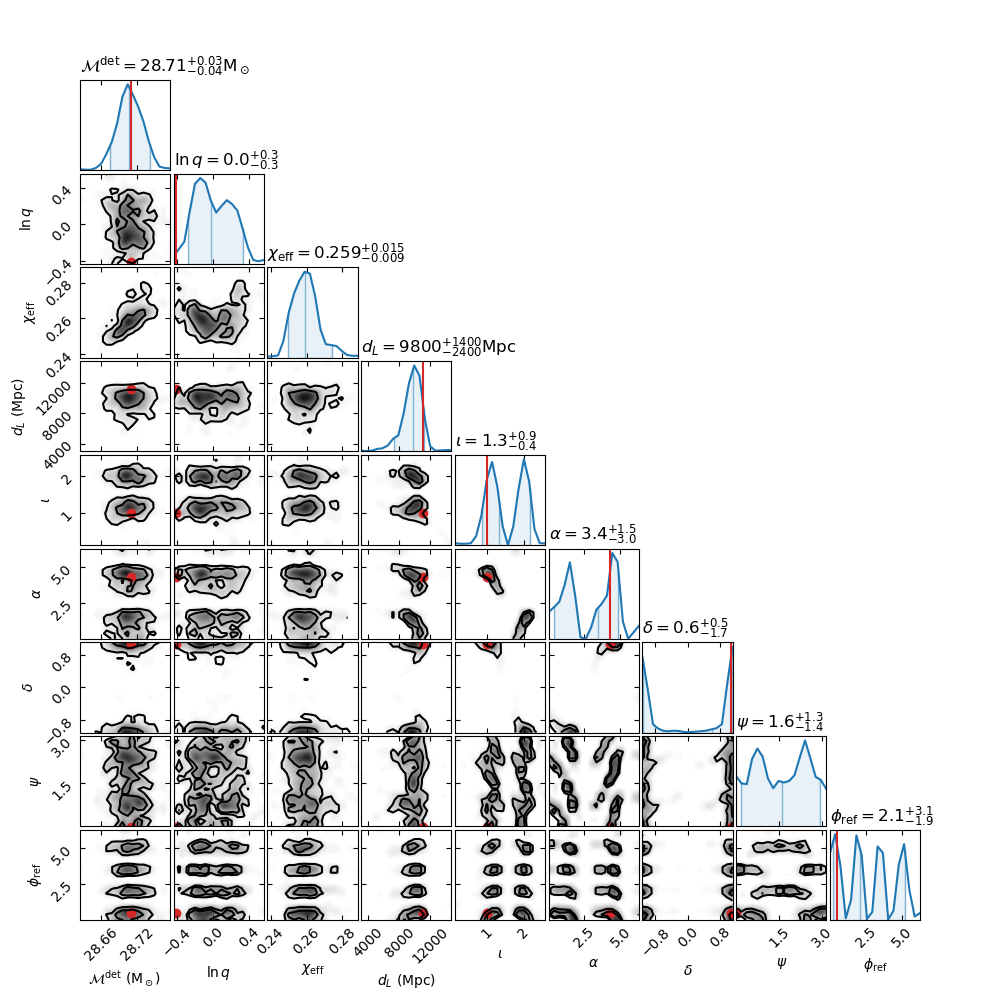

In [21]:
plot_params = ['mchirp', 'lnq', 'chieff', 'd_luminosity', 'iota', 
               'ra', 'dec', 'psi', 'phi_ref']

if 'chieff' not in samples.keys():
    samples['chieff'] = gw_utils.chieff(samples['m1'], samples['m2'], samples['s1z'], samples['s2z'])

cp = gw_plotting.CornerPlot(samples, params=plot_params)
cp.plot(max_n_ticks=3)

# I couldn't figure out the true parameters for the injection from the .h5 
# files as none of the tc seemed to match tgps
# In the absence of that, I'm going to mark the relative binning reference 
# waveform as the 'truth' in the plot for the sake of showing something
ref_par_dic = post.likelihood.par_dic_0.copy()
ref_par_dic.update(post.prior.inverse_transform(**ref_par_dic))

cp.scatter_points(ref_par_dic, colors=['C3'])